# Cross-Domain Federated Transfer Learning for Satellite Image Classification

This notebook implements transfer learning using a pretrained **ResNet-50** for classifying satellite images from the **EuroSAT** dataset into 10 land-use classes.

**Classes:** AnnualCrop, Forest, HerbaceousVegetation, Highway, Industrial, Pasture, PermanentCrop, Residential, River, SeaLake

---

### Setup Instructions
1. Go to **Runtime → Change runtime type** and select **T4 GPU** (or any available GPU)
2. Run all cells in order

## 1. Environment Setup & GPU Check

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from pathlib import Path
import os
import shutil
import random
import zipfile
import time

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"PyTorch version : {torch.__version__}")
print(f"Device          : {device}")
if torch.cuda.is_available():
    print(f"GPU             : {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory      : {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("WARNING: No GPU detected. Go to Runtime → Change runtime type → T4 GPU")

PyTorch version : 2.9.0+cu128
Device          : cuda
GPU             : Tesla T4
GPU Memory      : 15.6 GB


## 2. Download EuroSAT RGB Dataset

Downloads the EuroSAT RGB dataset (~90 MB) from the official source. This contains 27,000 Sentinel-2 satellite image patches across 10 land-use classes.

In [4]:
# Configuration
DATASET_URL = "https://zenodo.org/records/7711810/files/EuroSAT_RGB.zip"
DOWNLOAD_DIR = Path("Datasets")
ZIP_PATH = DOWNLOAD_DIR / "EuroSAT_RGB.zip"
SOURCE_DIR = DOWNLOAD_DIR / "EuroSAT_RGB"

# Download only if not already present
if SOURCE_DIR.exists() and any(SOURCE_DIR.iterdir()):
    print(f"Dataset already exists at {SOURCE_DIR}, skipping download.")
else:
    DOWNLOAD_DIR.mkdir(parents=True, exist_ok=True)
    print(f"Downloading EuroSAT RGB dataset...")
    !wget -q --show-progress -O "{ZIP_PATH}" "{DATASET_URL}"

    print("Extracting...")
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(DOWNLOAD_DIR)

    # Clean up zip file to save space
    ZIP_PATH.unlink()
    print(f"Dataset extracted to {SOURCE_DIR}")

# Show class folders and image counts
class_dirs = sorted([d for d in SOURCE_DIR.iterdir() if d.is_dir() and not d.name.startswith('.')])
total = 0
print(f"\nClasses found: {len(class_dirs)}")
for d in class_dirs:
    count = len(list(d.glob('*.jpg')))
    total += count
    print(f"  {d.name:30s} {count:5d} images")
print(f"{'Total':32s} {total:5d} images")

Datasets/EuroSAT_RG 100%[===================>]  90.27M  83.7MB/s    in 1.1s    
Extracting...
Dataset extracted to Datasets/EuroSAT_RGB

Classes found: 10
  AnnualCrop                      3000 images
  Forest                          3000 images
  HerbaceousVegetation            3000 images
  Highway                         2500 images
  Industrial                      2500 images
  Pasture                         2000 images
  PermanentCrop                   2500 images
  Residential                     3000 images
  River                           2500 images
  SeaLake                         3000 images
Total                            27000 images


## 3. Prepare Dataset — Train/Val Split

Splits the raw EuroSAT_RGB dataset into 80% train / 20% validation using a reproducible random split.

In [5]:
# ── Configuration ──────────────────────────────────────────────────
OUTPUT_DIR = Path("satellite_data")
TRAIN_RATIO = 0.8
SEED = 42


def split_dataset(source_dir: Path, output_dir: Path, train_ratio: float, seed: int):
    """
    Split each class folder into train and val subsets.

    Args:
        source_dir: Path to the raw EuroSAT_RGB directory.
        output_dir: Path to create the train/val directory structure.
        train_ratio: Fraction of images to use for training.
        seed: Random seed for reproducible splits.
    """
    random.seed(seed)

    # Get all class directories (skip hidden files)
    class_dirs = sorted([
        d for d in source_dir.iterdir()
        if d.is_dir() and not d.name.startswith(".")
    ])

    if not class_dirs:
        raise FileNotFoundError(f"No class folders found in {source_dir}")

    print(f"Source directory : {source_dir}")
    print(f"Output directory : {output_dir}")
    print(f"Train ratio      : {train_ratio}")
    print(f"Seed             : {seed}")
    print(f"Classes found    : {len(class_dirs)}")
    print()

    total_train = 0
    total_val = 0

    for class_dir in class_dirs:
        class_name = class_dir.name

        # Collect all image files in this class
        images = sorted([
            f for f in class_dir.iterdir()
            if f.is_file() and f.suffix.lower() in (".jpg", ".jpeg", ".png", ".tif")
        ])

        # Shuffle and split
        random.shuffle(images)
        split_idx = int(len(images) * train_ratio)
        train_images = images[:split_idx]
        val_images = images[split_idx:]

        # Create output directories
        train_dir = output_dir / "train" / class_name
        val_dir = output_dir / "val" / class_name
        train_dir.mkdir(parents=True, exist_ok=True)
        val_dir.mkdir(parents=True, exist_ok=True)

        # Copy files
        for img in train_images:
            shutil.copy2(img, train_dir / img.name)
        for img in val_images:
            shutil.copy2(img, val_dir / img.name)

        total_train += len(train_images)
        total_val += len(val_images)

        print(f"  {class_name:30s}  train: {len(train_images):5d}  val: {len(val_images):5d}")

    print()
    print(f"Total  train: {total_train}  val: {total_val}")


# Run the split
if OUTPUT_DIR.exists():
    print(f"Output directory {OUTPUT_DIR} already exists. Removing it for a clean split.")
    shutil.rmtree(OUTPUT_DIR)

split_dataset(SOURCE_DIR, OUTPUT_DIR, TRAIN_RATIO, SEED)
print(f"\nDataset prepared at: {OUTPUT_DIR.resolve()}")

Source directory : Datasets/EuroSAT_RGB
Output directory : satellite_data
Train ratio      : 0.8
Seed             : 42
Classes found    : 10

  AnnualCrop                      train:  2400  val:   600
  Forest                          train:  2400  val:   600
  HerbaceousVegetation            train:  2400  val:   600
  Highway                         train:  2000  val:   500
  Industrial                      train:  2000  val:   500
  Pasture                         train:  1600  val:   400
  PermanentCrop                   train:  2000  val:   500
  Residential                     train:  2400  val:   600
  River                           train:  2000  val:   500
  SeaLake                         train:  2400  val:   600

Total  train: 21600  val: 5400

Dataset prepared at: /content/satellite_data


## 4. Data Loading & Preprocessing

Sets up PyTorch DataLoaders with ImageNet-compatible preprocessing (resize to 224x224, normalize with ImageNet statistics).

In [6]:
# ── Configuration ──────────────────────────────────────────────────
DATA_DIR = "satellite_data"
BATCH_SIZE = 32
NUM_WORKERS = 2  # Colab works best with 2 workers


def get_transforms():
    """
    Create preprocessing transforms compatible with pretrained TorchVision models.

    Returns:
        dict: Dictionary containing 'train' and 'val' transforms.
    """
    # ImageNet normalization statistics (required for pretrained models)
    imagenet_mean = [0.485, 0.456, 0.406]
    imagenet_std = [0.229, 0.224, 0.225]

    # Training transforms: resize, convert to tensor, normalize
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to expected input size
        transforms.ToTensor(),           # Convert PIL Image to tensor [0, 1]
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
    ])

    # Validation transforms: same as training (no augmentation)
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
    ])

    return {'train': train_transform, 'val': val_transform}


def load_datasets(data_dir: str):
    """
    Load train and validation datasets using ImageFolder.
    """
    data_path = Path(data_dir)
    transforms_dict = get_transforms()

    train_dataset = datasets.ImageFolder(
        root=data_path / 'train',
        transform=transforms_dict['train']
    )

    val_dataset = datasets.ImageFolder(
        root=data_path / 'val',
        transform=transforms_dict['val']
    )

    return {'train': train_dataset, 'val': val_dataset}


def create_dataloaders(datasets_dict: dict, batch_size: int = 32, num_workers: int = 2):
    """
    Create DataLoaders for training and validation.
    """
    train_loader = DataLoader(
        datasets_dict['train'],
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )

    val_loader = DataLoader(
        datasets_dict['val'],
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    return {'train': train_loader, 'val': val_loader}


# Load datasets and create dataloaders
datasets_dict = load_datasets(DATA_DIR)
dataloaders = create_dataloaders(datasets_dict, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

# Print dataset info
train_dataset = datasets_dict['train']
print("=" * 50)
print("DATASET INFORMATION")
print("=" * 50)
print(f"\nNumber of classes   : {len(train_dataset.classes)}")
print(f"Class names         : {train_dataset.classes}")
print(f"Training samples    : {len(datasets_dict['train'])}")
print(f"Validation samples  : {len(datasets_dict['val'])}")

# Verify a sample batch
images, labels = next(iter(dataloaders['train']))
print(f"\nSample batch shape  : {images.shape}")
print(f"Labels shape        : {labels.shape}")
print(f"Tensor value range  : [{images.min():.4f}, {images.max():.4f}]")
print("\nDataset loading complete!")

DATASET INFORMATION

Number of classes   : 10
Class names         : ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Training samples    : 21600
Validation samples  : 5400

Sample batch shape  : torch.Size([32, 3, 224, 224])
Labels shape        : torch.Size([32])
Tensor value range  : [-1.7925, 2.6400]

Dataset loading complete!


## 5. Model — ResNet-50 Transfer Learning

Uses a pretrained ResNet-50 as a **fixed feature extractor**:
- All backbone parameters are frozen (~23.5M params)
- Only the final classification layer is trainable (~2,560 params)
- This avoids overfitting and trains very fast

In [7]:
NUM_CLASSES = 10


def create_model(num_classes: int = NUM_CLASSES) -> nn.Module:
    """
    Load a pretrained ResNet-50 and replace its classifier head.

    The backbone (all convolutional + batch norm layers) is frozen so that
    backpropagation only updates the new fully connected layer.
    """
    # Load ResNet-50 with pretrained ImageNet weights
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

    # Freeze every parameter in the backbone
    for param in model.parameters():
        param.requires_grad = False

    # Replace the final fully connected layer
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    return model


# Create model and move to GPU
model = create_model(num_classes=NUM_CLASSES)
model.to(device)

# Report parameter counts
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen = sum(p.numel() for p in model.parameters() if not p.requires_grad)
print(f"Device           : {device}")
print(f"Trainable params : {trainable:,}")
print(f"Frozen params    : {frozen:,}")
print(f"Total params     : {trainable + frozen:,}")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 162MB/s]


Device           : cuda
Trainable params : 20,490
Frozen params    : 23,508,032
Total params     : 23,528,522


## 6. Training

Trains the model for multiple epochs using Adam optimizer and CrossEntropyLoss.

In [8]:
# ── Configuration ──────────────────────────────────────────────────
NUM_EPOCHS = 10
LEARNING_RATE = 1e-3


def train_one_epoch(model, dataloader, optimizer, criterion, device):
    """Run one full training epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        correct += (outputs.argmax(dim=1) == labels).sum().item()
        total += labels.size(0)

    avg_loss = running_loss / total
    accuracy = 100.0 * correct / total
    return {"loss": avg_loss, "accuracy": accuracy}


def validate(model, dataloader, criterion, device):
    """Evaluate the model on the validation set."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(dim=1) == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / total
    accuracy = 100.0 * correct / total
    return {"loss": avg_loss, "accuracy": accuracy}


# ── Loss & Optimizer ───────────────────────────────────────────────
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LEARNING_RATE,
)

# ── Training Loop ──────────────────────────────────────────────────
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

print(f"Training for {NUM_EPOCHS} epochs...")
print(f"Learning rate: {LEARNING_RATE}")
print("=" * 70)

for epoch in range(1, NUM_EPOCHS + 1):
    start_time = time.time()

    train_metrics = train_one_epoch(model, dataloaders["train"], optimizer, criterion, device)
    val_metrics = validate(model, dataloaders["val"], criterion, device)

    elapsed = time.time() - start_time

    # Record history
    history["train_loss"].append(train_metrics["loss"])
    history["train_acc"].append(train_metrics["accuracy"])
    history["val_loss"].append(val_metrics["loss"])
    history["val_acc"].append(val_metrics["accuracy"])

    print(
        f"Epoch {epoch:2d}/{NUM_EPOCHS} "
        f"| Train Loss: {train_metrics['loss']:.4f} "
        f"| Train Acc: {train_metrics['accuracy']:6.2f}% "
        f"| Val Loss: {val_metrics['loss']:.4f} "
        f"| Val Acc: {val_metrics['accuracy']:6.2f}% "
        f"| Time: {elapsed:.1f}s"
    )

print("=" * 70)
print(f"Best Val Accuracy: {max(history['val_acc']):.2f}%")

Training for 10 epochs...
Learning rate: 0.001
Epoch  1/10 | Train Loss: 0.4694 | Train Acc:  85.41% | Val Loss: 0.2416 | Val Acc:  92.28% | Time: 84.9s
Epoch  2/10 | Train Loss: 0.2822 | Train Acc:  90.41% | Val Loss: 0.1866 | Val Acc:  93.70% | Time: 86.4s
Epoch  3/10 | Train Loss: 0.2565 | Train Acc:  91.07% | Val Loss: 0.1985 | Val Acc:  93.22% | Time: 86.7s
Epoch  4/10 | Train Loss: 0.2388 | Train Acc:  92.13% | Val Loss: 0.1842 | Val Acc:  93.41% | Time: 86.0s
Epoch  5/10 | Train Loss: 0.2246 | Train Acc:  92.21% | Val Loss: 0.1910 | Val Acc:  93.28% | Time: 86.8s
Epoch  6/10 | Train Loss: 0.2166 | Train Acc:  92.50% | Val Loss: 0.2065 | Val Acc:  92.48% | Time: 87.4s
Epoch  7/10 | Train Loss: 0.2095 | Train Acc:  92.85% | Val Loss: 0.1560 | Val Acc:  94.46% | Time: 86.5s
Epoch  8/10 | Train Loss: 0.2064 | Train Acc:  92.95% | Val Loss: 0.1734 | Val Acc:  93.89% | Time: 86.4s
Epoch  9/10 | Train Loss: 0.1932 | Train Acc:  93.19% | Val Loss: 0.1662 | Val Acc:  93.98% | Time: 86.8s

## 7. Training Curves

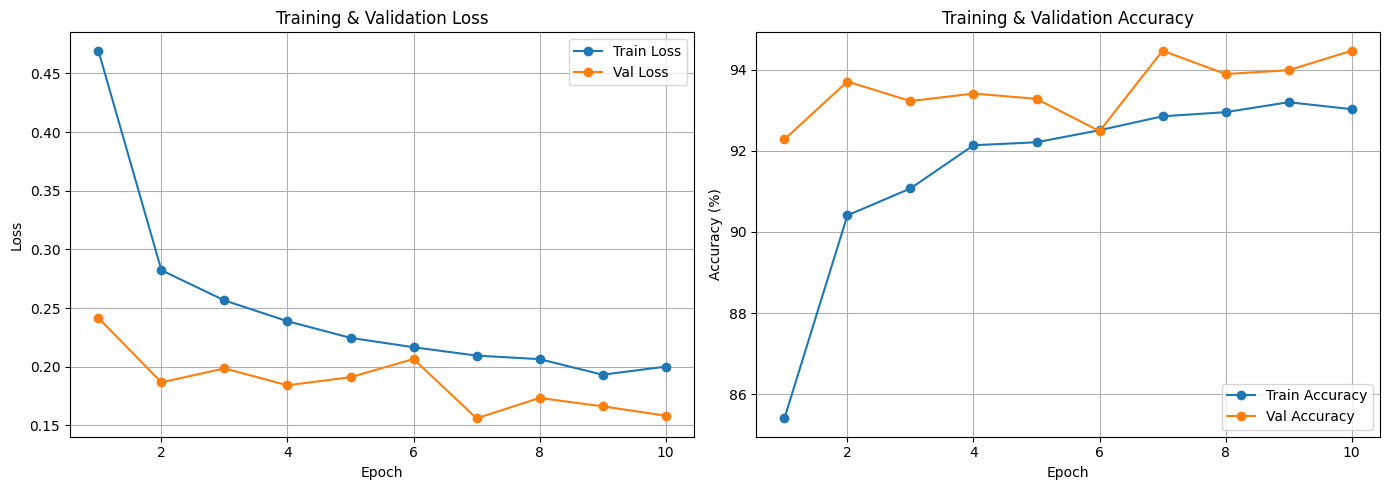

In [9]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

epochs_range = range(1, NUM_EPOCHS + 1)

# Loss plot
ax1.plot(epochs_range, history["train_loss"], "o-", label="Train Loss")
ax1.plot(epochs_range, history["val_loss"], "o-", label="Val Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Training & Validation Loss")
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(epochs_range, history["train_acc"], "o-", label="Train Accuracy")
ax2.plot(epochs_range, history["val_acc"], "o-", label="Val Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy (%)")
ax2.set_title("Training & Validation Accuracy")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## 8. Save Model

In [10]:
# Save the trained model
SAVE_PATH = "resnet50_eurosat.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'num_classes': NUM_CLASSES,
    'class_names': datasets_dict['train'].classes,
    'history': history,
}, SAVE_PATH)
print(f"Model saved to {SAVE_PATH}")

# Optional: Download the model file
# from google.colab import files
# files.download(SAVE_PATH)

Model saved to resnet50_eurosat.pth
